In [1]:
import pickle

import numpy as np
np.random.seed(108)
import pandas as pd

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from skimage import color, exposure

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.figure import Figure

from collections import Counter

%matplotlib inline

Using TensorFlow backend.


## Data

In [2]:
training_file = "input/train.p"
test_file = "input/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)

with open(test_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print(X_train.shape, X_test.shape)

(34799, 32, 32, 3) (4410, 32, 32, 3)


In [3]:
signnames = pd.read_csv('input/signnames.csv')

In [4]:
if y_train.ndim == 1: 
    y_train = to_categorical(y_train)
    
if y_test.ndim == 1: 
    y_test = to_categorical(y_test)    
    
input_shape = X_train.shape[1:]

traffic_labels_dict = signnames[['b']].to_dict()['b']
num_classes = len(traffic_labels_dict)

In [5]:
def preproc_img(img):
    hsv = color.rgb2hsv(img)
    hsv[:, :, 2] = exposure.equalize_adapthist(hsv[:, :, 2])
    img = color.hsv2rgb(hsv)

    return img

In [6]:
X_train_prp = X_train.copy().astype(np.float32)
X_test_prp = X_test.copy().astype(np.float32)

for i in tqdm(range(X_train.shape[0])):
    X_train_prp[i] = preproc_img(X_train[i])

  0%|          | 0/34799 [00:00<?, ?it/s]/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))
100%|██████████| 34799/34799 [10:17<00:00, 56.34it/s]


In [7]:
for i in tqdm(range(X_test.shape[0])):
    X_test_prp[i] = preproc_img(X_test[i])

  0%|          | 0/4410 [00:00<?, ?it/s]/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))
100%|██████████| 4410/4410 [01:22<00:00, 53.18it/s]


In [8]:
datagen = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.)

datagen.fit(X_train_prp)

## Model

In [9]:
def doubled_cnn3_with_bn():
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(32, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(64, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(128, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
        
    model.add(Flatten())
        
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model


model = doubled_cnn3_with_bn()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
__________

In [12]:
# Callbacks
tensorboard = TensorBoard('./logs/preproc', write_images=False)
model_cp = ModelCheckpoint('./logs/model/preproc/best_model.hdf5', save_best_only=True)
early_stop = EarlyStopping(patience=6)
reduce_rl = ReduceLROnPlateau(factor=0.2, patience=4)

## Train

In [13]:
history = model.fit_generator(datagen.flow(X_train_prp, y_train, batch_size=32),
                                           steps_per_epoch=X_train.shape[0]/32,
                                           epochs=30,
                                           verbose=1,
                                           validation_data=(X_test_prp, y_test),
                                           callbacks=[tensorboard, model_cp, early_stop, reduce_rl])

Epoch 1/30
1088/1087 [==============================] - 583s 535ms/step - loss: 0.3048 - acc: 0.9020 - val_loss: 0.1013 - val_acc: 0.9678
Epoch 2/30
1088/1087 [==============================] - 524s 481ms/step - loss: 0.1880 - acc: 0.9409 - val_loss: 0.1601 - val_acc: 0.9587
Epoch 3/30
1088/1087 [==============================] - 523s 481ms/step - loss: 0.1372 - acc: 0.9582 - val_loss: 0.0478 - val_acc: 0.9819
Epoch 4/30
1088/1087 [==============================] - 528s 485ms/step - loss: 0.1168 - acc: 0.9629 - val_loss: 0.0668 - val_acc: 0.9798
Epoch 5/30
1088/1087 [==============================] - 526s 484ms/step - loss: 0.0966 - acc: 0.9708 - val_loss: 0.0862 - val_acc: 0.9796
Epoch 6/30
1088/1087 [==============================] - 537s 493ms/step - loss: 0.0907 - acc: 0.9726 - val_loss: 0.0658 - val_acc: 0.9794
Epoch 7/30
1088/1087 [==============================] - 530s 487ms/step - loss: 0.0761 - acc: 0.9764 - val_loss: 0.0767 - val_acc: 0.9764
Epoch 8/30
1088/1087 [============

# Load best model

In [16]:
model.load_weights('./logs/model/preproc/best_model.hdf5')

## Evaluate

In [19]:
score = model.evaluate(X_test_prp, y_test, verbose=0)
# print(f'Test loss: {round(score[0], 2)}%')
print(f'Test accuracy: {round(score[1]*100, 2)}%')

#print(f'Error: {100-score[1]*100}%')

Test accuracy: 99.43%


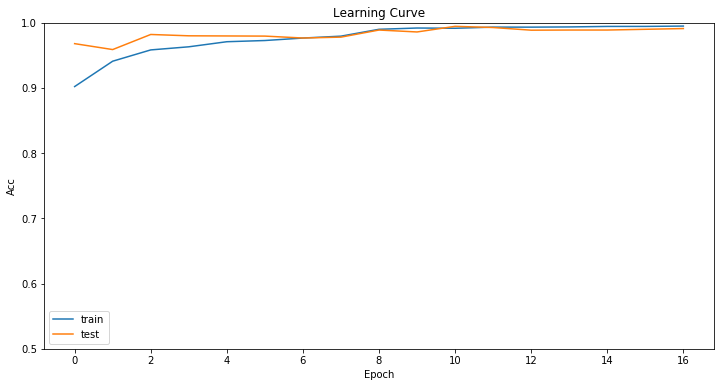

In [20]:
def draw_learning_curve(history, key='acc', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(history.history[key])
    plt.plot(history.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()
    
draw_learning_curve(history, key='acc', ylim=(0.5, 1.))
# draw_learning_curve(history, key='loss', ylim=(0., 1.))